# Best Trotter Steps

We would like to know, given a certain final time $t$, which is the optimal number of Trotter steps $N_t$ that minimizes the error. The latter has two main components:
* Trotter error $\epsilon_{tr}$
* Circuit error $\epsilon_{circ}$

## Trotter error

We found a formula in [The Theory of Trotter Error with Commutator Scaling](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.011020) for $k$-local Hamiltonians:

$$ \epsilon_{tr} = n^k ||| H |||_1 || H ||_1^{o(1)} t^{1+o(1)}$$

where, in our case, $k=3$ for the three-body interaction term (matter-gauge-matter), $n$ is the number of spins (qubits), $t$ is the final time, and $|||\cdot|||_1$ is the _induced 1-norm_ of the operator $\cdot$.

### Semplifications

The induced 1-norm for an operator $A$ is upper bounded by the 1-norm
$$||| A |||_1 \leq || A ||_1 $$
and the $|| A ||_1$ corresponds to the sum of the largest singular values of the $\Gamma$ summands of $A$, that is, $\sum_{\gamma=1}^{\Gamma} ||A_{\gamma}||$.

So that we have to find $\left(|| H ||_1\right)^2$.

### Hamiltonian:

$$H = - J \sum_n \tau_n^{z} - h \sum_n \sigma_{(n, n+1)}^{z} - \lambda \sum_n \tau^{x}_{n+1} \sigma_{(n, n+1)}^{x} \tau^{x}_n$$

We can use **sub-additive**, **scalar multiplication**, and **triangular inequality** to find

$$||H||_1 \leq \left|J\right| \left|\left|\sum_n \tau_n^{z}\right|\right| + \left|h\right| \left|\left| \sum_n \sigma_{(n, n+1)}^{z}\right|\right| + \left|\lambda\right|  \left|\left| \sum_n \tau^{x}_{n+1} \sigma_{(n, n+1)}^{x} \tau^{x}_n\right|\right| $$


In [1]:
from z2chain.exact import sparse_hamiltonian
from scipy.sparse.linalg import svds
from numpy.linalg import svd

L = 3 # dual space sites
n = 2*L-1 # qubits, (n//2)+1 of matter and n//2 of gauge
J = 1
h = 0.05
lamb = 0.7
H = sparse_hamiltonian(J=J,h=h,lamb=lamb,chain_length=L)
print(f"qubits: {n}, matter sites: {n//2+1}, gauge sites: {n//2}")

u,s_sp,v = svds(H)
print(max(s_sp), len(s_sp))

# u,s,v = svd(H.toarray())
# print(max(s), len(s))

qubits: 5, matter sites: 3, gauge sites: 2
3.338025464577649 6


In [32]:
def hamiltonian_norm_bound(hamiltonian_params):
    if hamiltonian_params.get('ham_name') == "z2higgs":
        chain_length = hamiltonian_params.get('chain_length')
        J = hamiltonian_params.get('J')
        h = hamiltonian_params.get('h')
        lamb = hamiltonian_params.get('lamb')
        n = 2*chain_length - 1
        matter_norm = J*chain_length
        gauge_norm = h*(chain_length-1)
        int_norm = lamb*(chain_length-1)
        return matter_norm + gauge_norm + int_norm

def complexity_trotter_error_bound(k: int, final_time: float, params: dict):
    H_norm = hamiltonian_norm_bound(hamiltonian_params=params)
    chain_length = params.get('chain_length')
    n = 2*chain_length - 1
    return n**k * H_norm**2 * final_time

def trotter_error_bound(p_order: int, final_time: float, trotter_steps: int, params: dict):
    H_norm = hamiltonian_norm_bound(hamiltonian_params=params)
    return H_norm**(p_order+1) * final_time**(p_order+1) / trotter_steps**p_order

def trotter_step_bound(p_order: int, final_time: float, error: int, params: dict):
    H_norm = hamiltonian_norm_bound(hamiltonian_params=params)
    return H_norm**(1+1/p_order) * final_time**(1+1/p_order) / error**(1/p_order)

In [37]:
L = 10
J = 1
h = 0.05
lamb = 0.7
final_time = 8
layers = 25
model = "z2higgs"
hamiltonian_params = dict(chain_length=L, J=J, h=h, lamb=lamb, ham_name=model)
eps_tr = complexity_trotter_error_bound(k=3, final_time=8, params=hamiltonian_params)
print(f"for t: {final_time}, and {2*L-1} qubits we have Trotter error complexity: {eps_tr}")
eps_tr = trotter_error_bound(p_order=2, final_time=8, trotter_steps=layers, params=hamiltonian_params)
print(f"for t: {final_time}, and {2*L-1} qubits we have Trotter error bound: {eps_tr}")
eps_tr = trotter_step_bound(p_order=2, final_time=8, error=1e-1, params=hamiltonian_params)
print(f"for t: {final_time}, and {2*L-1} qubits we have Trotter error bound: {eps_tr}")

for t: 8, and 19 qubits we have Trotter error complexity: 15395025.5
for t: 8, and 19 qubits we have Trotter error bound: 3849.7664
for t: 8, and 19 qubits we have Trotter error bound: 4905.205398349798


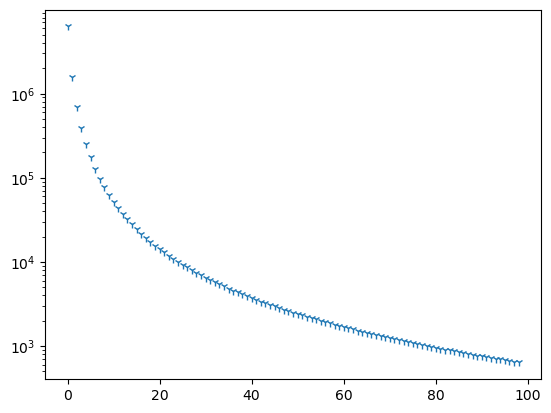

In [4]:
import matplotlib.pyplot as plt
error_trotter = []
for layers in range(1,100):
    eps_tr = trotter_error_bound(p_order=2, final_time=8, trotter_steps=layers, params=hamiltonian_params)
    error_trotter.append(eps_tr)

plt.plot(error_trotter, '1')
plt.yscale('log')

## Circuit Error

We use as a first estimate the Error Per Layered Gate (EPLG) which is specific of the chosen backend. 

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
# from cobos.tokens import ibm_token, group_instance
from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
# device = "ibm_kyiv"
# device = "ibm_fez"
# device = "ibm_sherbrooke"
device = "ibm_torino"

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

In [6]:
L = 12
J = 1
h = 0.05
lamb = 0.7

x_basis = False

particle_pair_left_position = L//2 - 1
particle_pair_length = 1

final_time = 8
layers = 25
measure_every_layers = 1

Longest circuit has 100 2-qb depth


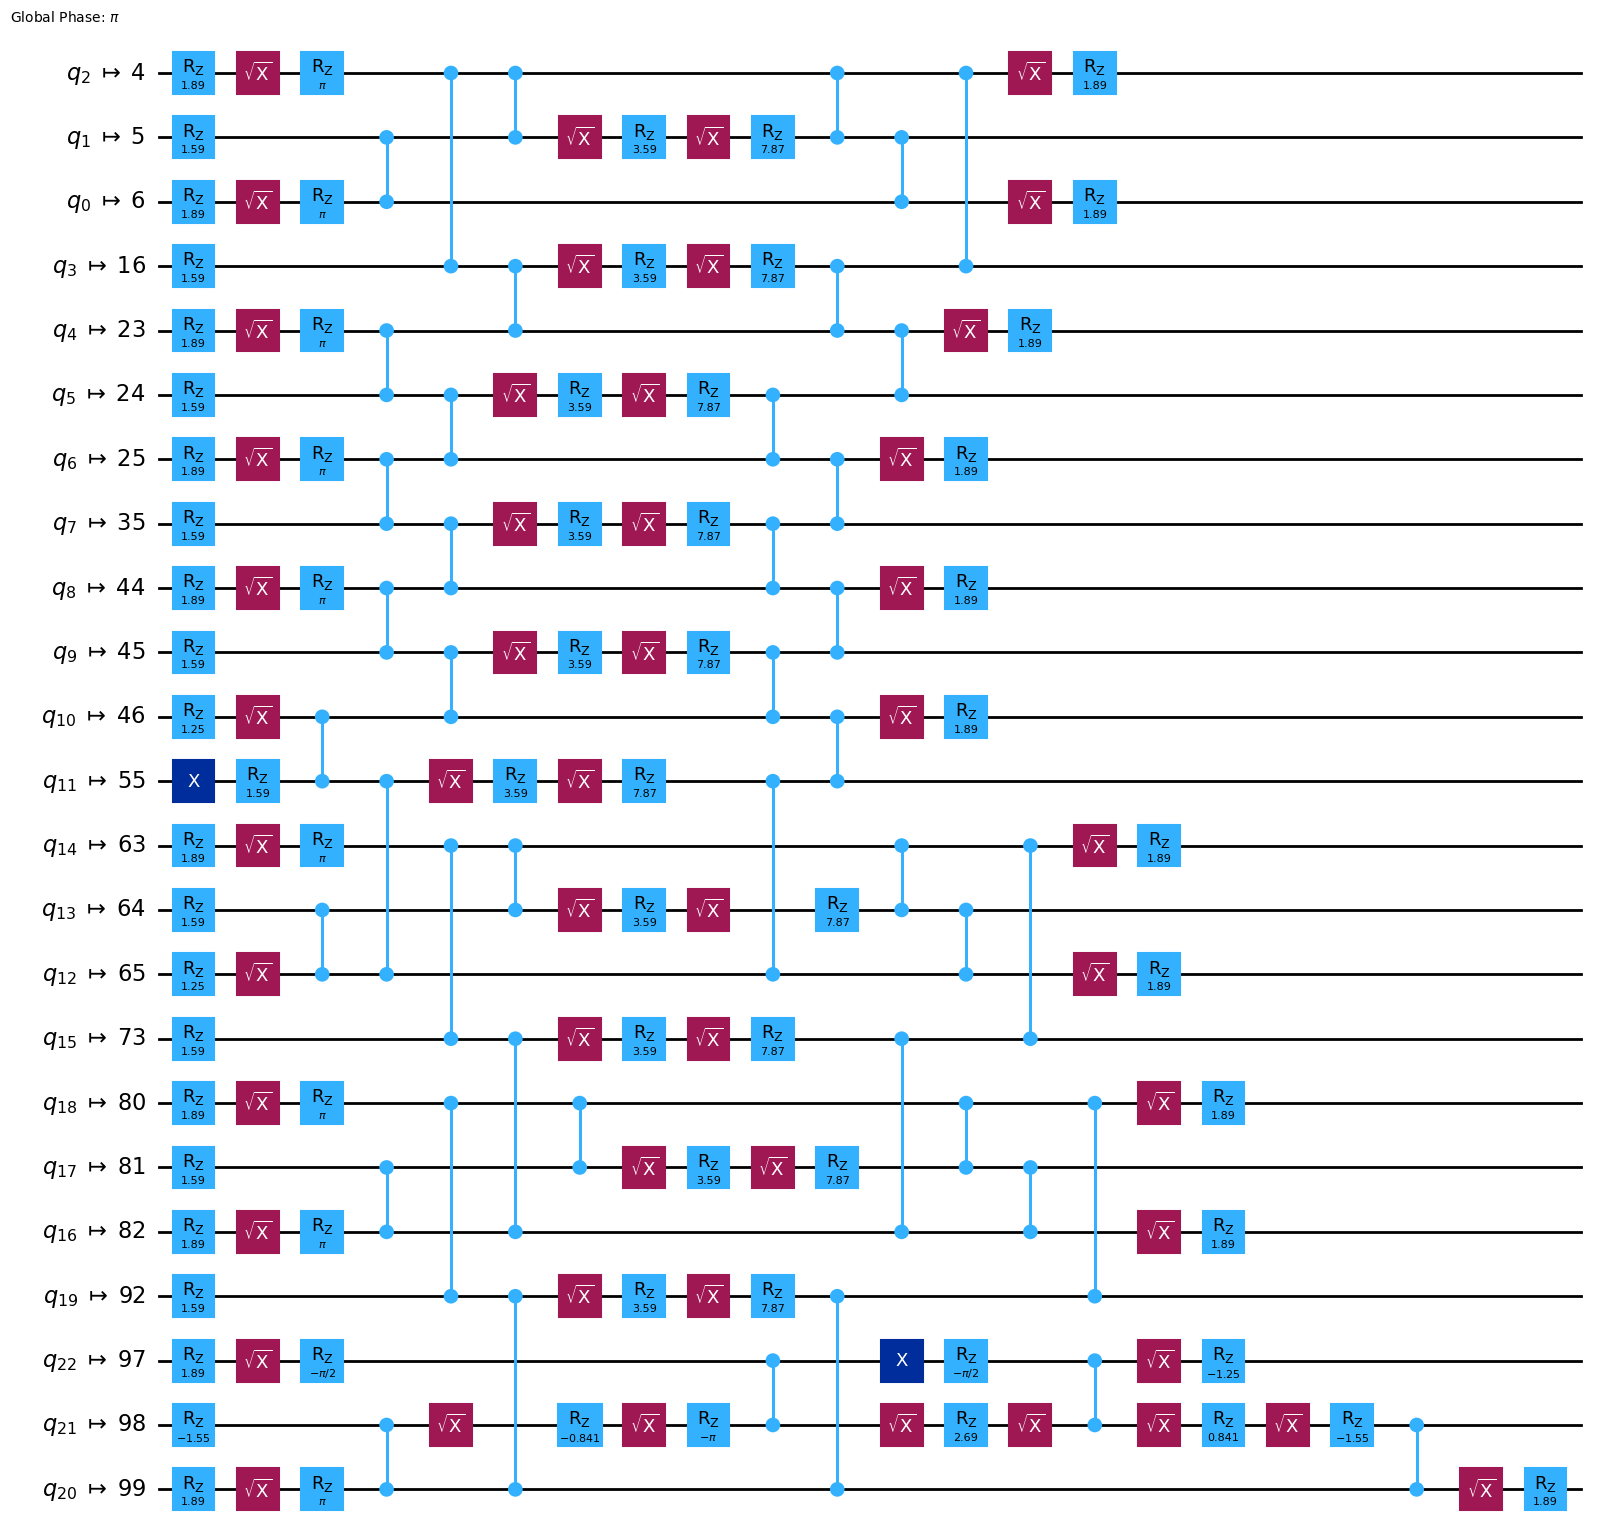

In [8]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits

optimization_level = 2

qubits_inds = None
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22]
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22, 21, 20, 33, 39, 40,
#                41, 42, 43, 44, 45, 54, 64, 63, 62, 72, 
#                81, 82, 83, 92, 102, 103, 104, 111, 122,
#                121, 120, 119, 118, 116, 115, 114, 109, 96, 95]

physical_circuits = physical_particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, backend, optimization_level, qubits_inds, measure_every_layers=measure_every_layers, x_basis=x_basis)
longest_2qb_depth = physical_circuits[-1].depth(lambda x: len(x.qubits) == 2)
print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
physical_circuits[1].draw(output="mpl", idle_wires=False, fold=-1, filename="transpiled_circuit.png")

In [17]:
dir(physical_circuits[0].layout)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_input_qubit_count',
 '_output_qubit_list',
 'final_index_layout',
 'final_layout',
 'final_virtual_layout',
 'initial_index_layout',
 'initial_layout',
 'initial_virtual_layout',
 'input_qubit_mapping',
 'routing_permutation']

In [23]:
import numpy as np

def circuit_error_bound(physical_circuit, backend, layers: int):
    physical_layout = physical_circuits[0].layout.final_index_layout()

    readout_errs = []
    for qubit in physical_layout:
        err = backend.properties().readout_error(qubit=0)
        readout_errs.append(err)

    av_readout_err = np.mean(readout_errs)
    return layers * av_readout_err

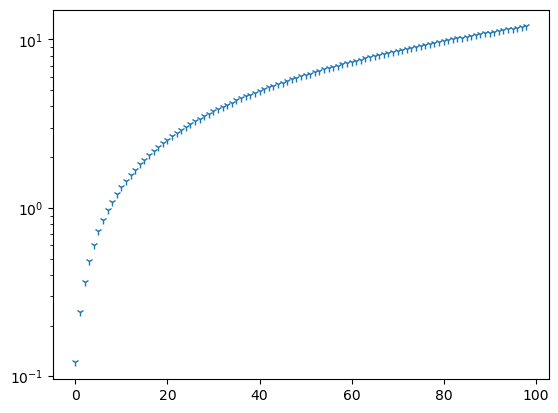

In [24]:
error_circ = []
for layers in range(1,100):
    eps_circ = circuit_error_bound(physical_circuit=physical_circuits[0], backend=backend, layers=layers)
    error_circ.append(eps_circ)

plt.plot(error_circ, '1')
plt.yscale('log')

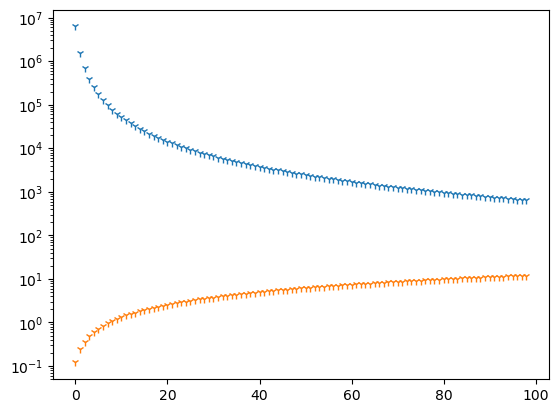

In [25]:
plt.plot(error_trotter, '1')
plt.plot(error_circ, '1')
plt.yscale('log')